# Assignment 7 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
import astropy
import math
%matplotlib inline

## Problem 1

Functions defined in my_transit: Code from Prof. Bryan

In [2]:
# This implements the planet obscuration function for a uniform
#  (stellar) disk described in Mandel & Agol (2002).
#  http://dx.doi.org/10.1086/345520


'''
Functions used in calculating transit light curves 
 Variables/ Arguments meaning for problem:
     p = r_p/r_* : size ratio of planet to the star
         where r_p is the radius of the planet,; r_* is the stellar radius
     z = d/r_* : is the separation of the centers, normalized by the stellar 
         where d is center-to-center distance between the star and the planet
     F(p,z) is observed flux relative to the unobscured flux
'''

def kappa0(p, z):
    return acos((p**2 + z**2 - 1)/(2*p*z))

def kappa1(p, z):
    return acos((1 - p**2 + z**2)/(2*z))

def lambd(p, z):
    if 1 + p < z:
        return 0
    if z <= 1 - p:
        return p**2
    if z <= p - 1:
        return 1
    arg = (4*z**2 - (1 + z**2 - p**2)**2)/4
    if arg >= 0:
        return (kappa0(p, z)*p**2 + kappa1(p, z) - math.sqrt(arg))/pi
    else:
        return 0

def FluxRatio(p, z):
    """
    Compute the ratio of obscured/unobscured flux for a planet transit.
    
    Arguments:
       p - ratio of planet radius to stellar radius
       z - distance between star and planet divided by stellar radius
    Returns: 
       FluxRatio - ratio of obscured to unobscured stellar flux
    """
    return 1 - lambd(p, abs(z))

# The following functions are used in computing the transit light curve

def beta(p, r, z):
    return 2.0 * math.acos((z**2 - p**2 + r**2)/(2*z*r))

def delta(p, r, z):
    """
    Compute the ratio of obscured/unobscured flux for a planet transit
       for a given radial ring.
    
    Arguments:
       p - ratio of planet radius to stellar radius
       r - radius of ring (divided by stellar radius)
       z - distance between star and planet divided by stellar radius
    Returns: 
       delta - ratio of obscured to unobscured stellar flux for that radius
    """
    if r >= z + p or r <= z - p:
        return 0
    if r + z <= p:
        return 1
    b = beta(p, r, z)
    return b/(2*math.pi)


def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu)**0.5)

def func1(r, p, z):
    '''Numerator for the transit integral'''
    return I(r) * (1 - delta(p,r,abs(z))) * 2 * r

def func2(r, p, z):
    '''Denominator for the transit integral'''
    return I(r) * 2 * r

def ComputeLightCurve(time, p, t0, tau):
    """ Convert from Time to z and compute predicted transit curve. Given the three
        parameters p, t0, and tau as well as an array containing the time values,
        returns the predicted (normalized) transit flux values as an array"""
    zs = (time-t0)/tau
    FluxRatio = []
    for zval in zs:
        FluxObscured, FO_error = quad(func1, 0.0, 1.0, epsrel=1e-06, args=(p,zval))
        FluxUnobscured, FU_error = quad(func2, 0.0, 1.0, epsrel=1e-06, args=(p,zval))
        FluxRatio.append(FluxObscured/FluxUnobscured)
    return np.array(FluxRatio)

Import and normalize data

In [3]:
##### import data
time, flux, flux_err = np.loadtxt('KOI97.01_1.out', unpack=True)

# Extract section that corresponds to a single eclipse (124 < t < 125): UTC units: 2,454,833 days
eclipse_interval = np.where((time < 125.0) & (time > 124.0))

time = time[eclipse_interval] # time interval
flux = flux[eclipse_interval] # flux interval
flux_err = flux_err[eclipse_interval] # Uncertainty in flux

# Normalize Flux
    
# Two sigma clipping
def two_sigma_clip(data,n):
    flux_prime, sigma_prime = np.median(data), np.std(data)
    # used median to mitigate contributions from outliers
    unobscured_flux = np.where((abs(flux - flux_prime) / sigma_prime) <= 2)
    return flux[unobscured_flux] #unobstructed flux
    
    # loop to get better analysis
    i = 0
    while i < n:
        f = sigma_clipping(flux[unobscured_flux])
        i += 1
    
    return f

# iterate loop 5x to normalize data
unobsc_flux = two_sigma_clip(flux, 5)
mean_flux = np.mean(unobsc_flux)
print('Mean flux is', mean_flux)

norm_flux, norm_err = flux / mean_flux, flux_err / mean_flux

print('N =', len(norm_flux))

Mean flux is 104170.515625
N = 49


Fit and Chi Square

In [5]:
def chi_square(y, fit, sigma):
    return np.sum((y - fit)**2 / sigma**2)

# fit the light curve
fit = ComputeLightCurve(time, p = 0.0775, t0 = 124.5, tau = 0.1)
chi_2 = chi_square(norm_flux, fit, norm_err)
print('chi square =', chi_2)

chi square = 830.6171796711525


Tying with ready-made functions in astropy and scipy

In [35]:
from astropy.stats import sigma_clip
from scipy.stats import chisquare

unobsc_flux2 = sigma_clip(flux, sigma=2, maxiters=5)
#print(unobsc_flux2)

mean_flux2 = np.mean(unobsc_flux2)
print('%.4f'%mean_flux2)

norm_flux2, norm_err2 = flux / mean_flux2, flux_err / mean_flux2

# fit the light curve
chi2_2 = chisquare(norm_flux2, fit)
print('chi2 =', chi2_2)

104179.3469
chi2 = Power_divergenceResult(statistic=7.306342957790779e-05, pvalue=1.0)


## Problem 2: Plotting/Fit

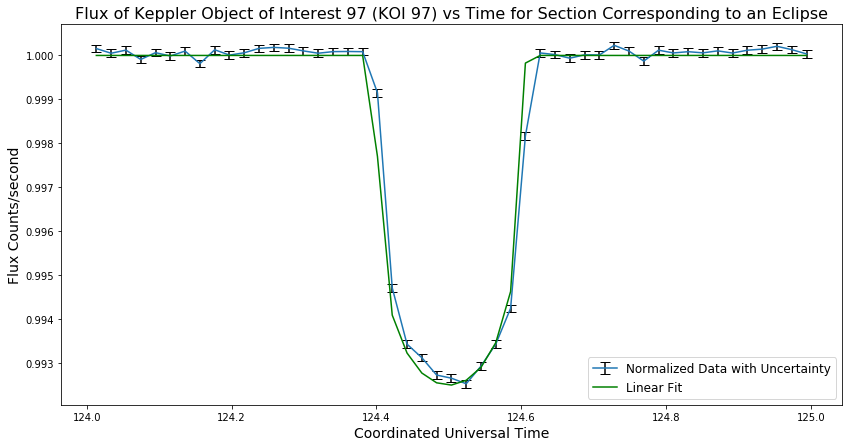

In [8]:
# plot the data and the predicted transit curve

# Set up figure with subplots
fig1, ax1 = plt.subplots(figsize = (14, 7))

# Graph 1: direct from data
ax1.errorbar(x = time, y = norm_flux,
            yerr = norm_err, fmt = '-', ecolor = 'k', capsize = 5, 
             label = 'Normalized Data with Uncertainty')

# Graph 1: linear fit
ax1.errorbar(x = time, y = fit,
           fmt = '-', color = 'green', label = 'Linear Fit')

ax1.set_xlabel('Coordinated Universal Time', fontsize = 14)
ax1.set_ylabel('Flux Counts/second', fontsize = 14)
ax1.set_title('Flux of Keppler Object of Interest 97 (KOI 97) vs Time for Section Corresponding to an Eclipse', 
              fontsize = 16)
ax1.legend(loc = 4, fontsize = 12)

plt.show()

Fit is not great, but it also doesn't look that bad. I would use it.

Determining how likely is the chi square value

In [9]:
# Finding incomplete gamma function

nu = len(norm_flux)-3
p_val = scipy.special.gammainc (nu/2, chi_2/2)
print('p-value of fit is',  p_val)

p-value of fit is 1.0


P-value indicates it is not a good fit.

### Problem 3: varying tau 

In [34]:
chi2_list = []

tau_list = np.linspace(0.08, 0.13, 100)

for tau in tau_list:
    fit = ComputeLightCurve(time, p = 0.0775, t0 = 124.5, tau = tau)    
    chi2_list.append(chi_square(norm_flux, fit, norm_err))
    
print('%.4f'%min(chi2_list))

650.9605


Plot

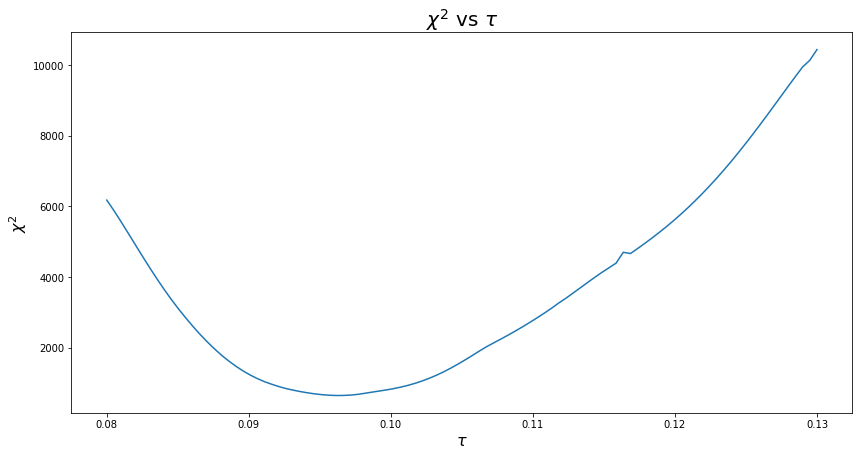

In [17]:
fig2, ax2 = plt.subplots(figsize = (14, 7))

ax2.errorbar(tau_list, chi2_list, fmt = '-', ecolor = 'k', capsize = 5)

ax2.set_xlabel(r'$\tau$', fontsize = 16)
ax2.set_ylabel(r'$\chi^2$', fontsize = 16)
ax2.set_title(r'$\chi^2$ vs $\tau$', 
              fontsize = 20)

plt.show()

In [30]:
ind = np.argmin(chi2_list)
print(ind)

32


In [33]:
print('\u03C4 corresponding to minimum \u03C7^2 is', '%.4f'%tau_list[32])

p_val2 = scipy.special.gammainc (nu/2, min(chi2_list)/2)
print('p-value of fit is',  p_val2)

τ corresponding to minimum χ^2 is 0.0962
p-value of fit is 1.0


Determine 1 $\sigma$ uncertainty